In [ ]:
# ###################################
# Group ID : 713
# Members : Isabella Quillo, Jacob Mørk, Anders Lauridsen, and Jakob Olsen
# Date : 14 september 2022
# Lecture: 3 - Parametric and nonparametric methods (see moodle)
# Dependencies: Toolbox, library, etc. needed to run, e.g., Libsvm, netlab, LDA tool.
# Python version: Python 3.9.12
# Functionality: Short Description. Example: This script trains a MLP for classifying
# handwritten digits. It also test the performance on a given data set for various
# settings.
# ###################################

In [130]:
import numpy as np
import os
from scipy.stats import multivariate_normal as mn
import matplotlib.pyplot as plt


def largest_indices(ary, n):
    """Returns the n largest indices from a numpy array."""
    flat = ary.flatten()
    indices = np.argpartition(flat, -n)[-n:]
    indices = indices[np.argsort(-flat[indices])]
    return np.unravel_index(indices, ary.shape)[0]



path = os.getcwd()
n_dim = 2

In [6]:
test = []
train = []

for i in range(10):
    test.append(np.loadtxt(path + f"/data/test{i}.txt"))
    train.append(np.loadtxt(path + f"/data/test{i}.txt"))

In [52]:
# Combine traning data in a new matrix
classes = [5, 6, 8]
datasets = [train[k] for k in classes]
combined_data = np.vstack(datasets)

In [58]:
# Calculate the covariance of the data, and the associated eigenvalues and vectors
covariance = np.cov(combined_data.T)
eigenvalues, eigenvectors = np.linalg.eig(covariance)

In [96]:
# Create projection matrix
largest_idx = largest_indices(eigenvalues, n_dim)
proj_matrix = np.vstack([eigenvectors[:, idx] for idx in largest_idx]).T

In [97]:
# create sample mean and test data
test_data = np.vstack([test[k] for k in classes])
sample_mean = np.mean(test_data, axis = 0)

In [109]:
# Calculate the projected data
projected_data = proj_matrix.T @ (test_data - sample_mean).T
projected_data = projected_data.real  # Disregarding the complex part becuase it is 0 (this was verified by computation)

In [111]:
# Split the projected data according to which number they actually came from
proj5 = projected_data[:, :len(test[5])]
proj6 = projected_data[:, len(test[5]):len(test[5])+len(test[6])]
proj8 = projected_data[:, len(test[5])+len(test[6]):]

In [173]:
def classify(point, mean_5, mean_6, mean_8, cov_5, cov_6, cov_7, prior_5, prior_6, prior_8):
    prob_5 = mn.pdf(point, mean_5, cov_5, allow_singular=True) * prior_5
    prob_6 = mn.pdf(point, mean_6, cov_6, allow_singular=True) * prior_6
    prob_8 = mn.pdf(point, mean_8, cov_8, allow_singular=True) * prior_8

    probs = [prob_5, prob_6, prob_8]
    idx = np.argmax(probs)

    match idx:
        case 0:
            return 5
        
        case 1:
            return 6
        
        case 2:
            return 8
        
        case _:
            print("you messed up")
            return 0


# Set up everything for classification of the data
N = sum([len(train[k]) for k in classes])

# Project training data
p_trn_data_5 = proj_matrix.T @ (train[5] - np.mean(train[5], axis=0)).T
p_trn_data_6 = proj_matrix.T @ (train[6] - np.mean(train[6], axis=0)).T
p_trn_data_8 = proj_matrix.T @ (train[8] - np.mean(train[8], axis=0)).T

# compute priors
pc_5 = len(p_trn_data_5) / N
pc_6 = len(p_trn_data_6) / N
pc_8 = len(p_trn_data_8) / N

# compute means and covariacnes
m_5 = np.mean(p_trn_data_5, axis=1)
m_6 = np.mean(p_trn_data_6, axis=1)
m_8 = np.mean(p_trn_data_8, axis=1)
cov_5 = np.cov(p_trn_data_5)
cov_6 = np.cov(p_trn_data_6)
cov_8 = np.cov(p_trn_data_8)

# Classify the points
results = np.zeros(N)
for i, point in enumerate(projected_data.T):
    result = classify(point, m_5, m_6, m_8, cov_5, cov_6, cov_8, pc_5, pc_6, pc_8)
    results[i] = result

/home/aau/uni_python/lib/python3.10/site-packages/scipy/stats/_multivariate.py:385: ComplexWarning: Casting complex values to real discards the imaginary part
  mean = np.asarray(mean, dtype=float)
/home/aau/uni_python/lib/python3.10/site-packages/scipy/stats/_multivariate.py:400: ComplexWarning: Casting complex values to real discards the imaginary part
  cov = np.asarray(cov, dtype=float)


In [187]:
# Get guesses for each of the classes
results_5 = results[:len(test[5])]
results_6 = results[len(test[5]): len(test[5]) + len(test[6])]
results_8 = results[len(test[5]) + len(test[6]):]

# Get the accuracy of the classification
accuracy_5 = len(np.where(results_5 == 5)[0]) / len(test[5])
accuracy_6 = len(np.where(results_6 == 6)[0]) / len(test[6])
accuracy_8 = len(np.where(results_8 == 8)[0]) / len(test[8])

43.05% of the 5's were identified correctly
49.48% of the 6's were identified correctly
19.30% of the 8's were identified correctly


In [228]:
# Create arrays according to classification
class_5 = []
class_6 = []
class_8 = []

for i, r in enumerate(results):
    match r:
        case 5:
            class_5.append(projected_data[:, i])

        case 6:
            class_6.append(projected_data[:, i])
        
        case 8:
            class_8.append(projected_data[:, i])
        
        case _:
            print(":c")

class_5 = np.array(class_5).T
class_6 = np.array(class_6).T
class_8 = np.array(class_8).T

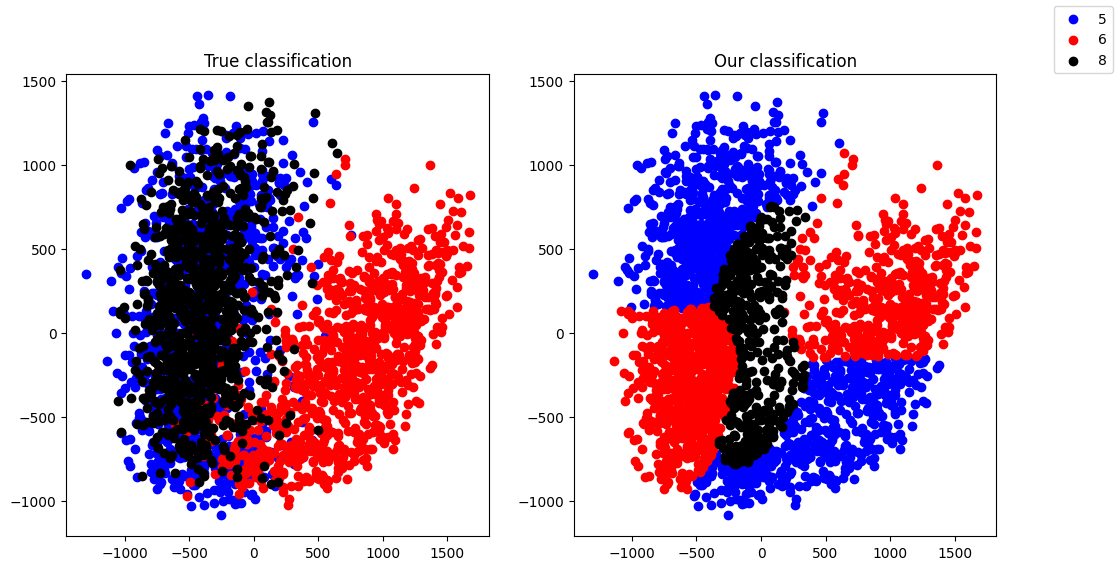

43.05% of the 5's were identified correctly
49.48% of the 6's were identified correctly
19.30% of the 8's were identified correctly


In [230]:
# Plot the classification alongside the true values
fig, ax = plt.subplots(1, 2)

ax[0].scatter(proj5[0], proj5[1], label="5", c="b")
ax[0].scatter(proj6[0], proj6[1], label="6", c="r")
ax[0].scatter(proj8[0], proj8[1], label="8", c="k")
ax[0].set_title("True classification")

ax[1].scatter(class_5[0], class_5[1], c="b")
ax[1].scatter(class_6[0], class_6[1], c="r")
ax[1].scatter(class_8[0], class_8[1], c="k")
ax[1].set_title("Our classification")

fig.set_size_inches(12, 6)
fig.legend()
plt.show()

# print results
print(f"{accuracy_5*100:.2f}% of the 5's were identified correctly")
print(f"{accuracy_6*100:.2f}% of the 6's were identified correctly")
print(f"{accuracy_8*100:.2f}% of the 8's were identified correctly")